In [432]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pymongo
from collections import Counter
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import cm

In [3]:
def create_dataframe(recipes, cutoff=2):
    recipe_ids = _get_recipe_ids(recipes)
    common_ingredients = _get_common_ingredients(recipes, cutoff=cutoff)
    df = pd.DataFrame(columns=common_ingredients, index=recipe_ids).fillna(0)
    unknown_servings = []
    for recipe in recipes:
        idx = recipe['id']
        servings = recipe['directions']['servings']
        if not servings:
            unknown_servings.append(recipe)
            #print('Servings missing')
            continue
        for ing, qty in recipe['ingredients'].items(): 
            norm_qty = qty['normalized_qty']
            if ing in df.columns:
                df.loc[idx, ing] = norm_qty / servings
    # Determine approx servings for recipes where it is not specified
    for recipe in unknown_servings:
        servings = _approximate_servings(recipe, df)
        recipe['directions']['approx_servings'] = servings
    # Apply approx servings to recipes and insert data into dataframe
    for recipe in unknown_servings:
        servings = recipe['directions']['approx_servings']
        for ing, qty in recipe['ingredients'].items(): 
            norm_qty = qty['normalized_qty']
            if ing in df.columns:
                df.loc[idx, ing] = norm_qty / servings
    return df

def _get_recipe_ids(recipes):
    recipe_ids = []
    for recipe in recipes:
        recipe_ids.append(recipe['id'])
    return recipe_ids

def _approximate_servings(recipe, df):
    recipe_qtys = []
    df_means = []
    for ing, qty in recipe['ingredients'].items():
        if ing in df.columns:
            recipe_qtys.append(qty['normalized_qty'])
            ing_vals = df[df[ing] != 0][ing]
            df_means.append(np.mean(ing_vals))
    qtys_array = np.array(recipe_qtys)
    df_means_array = np.array(df_means)
    count = 1
    while True:
        err = np.mean(abs(qtys_array/count - df_means_array)) * count
        next_err = np.mean(abs(qtys_array/(count+1) - df_means_array)) * (count+1)
        if next_err > err:
            return count
        count += 1
        err = next_err
        
def _get_common_ingredients(recipes, cutoff=2):
    ingredients = Counter()
    for recipe in recipes:
        for ing in recipe['ingredients'].keys():
            ingredients[ing] += 1
    #print('Number of unique ingredients :', len(ingredients))
    common_ingredients = []
    for item, count in ingredients.most_common():
        if count >= cutoff:
            common_ingredients.append(item)
    #print('Number of common ingredients :', len(common_ingredients))
    return common_ingredients

def get_label_names(recipes, cat_lvl=2):
    labels = []
    key = 'lvl_{}'.format(cat_lvl)
    for recipe in recipes:
        labels.append(recipe['category'][key])
    return labels

def get_label_numbers(label_names, limit=None):
    ordered_names = [key for key, val in Counter(label_names).most_common()]
    label_nums = [ordered_names.index(label) for label in label_names]
    if not limit:
        return label_nums
    else:
        return [num if num < limit-1 else limit-1 for num in label_nums]
    
def scale_dataframe(df):
    means = np.mean(df, axis=0)
    stds = np.std(df, axis=0)
    return (df - means) / stds, means, stds

In [4]:
mc = pymongo.MongoClient()
db = mc['allrecipes']
recipes_coll = db['recipes']

In [393]:
cursor = recipes_coll.find()
chili_recipes = []
for recipe in cursor:
    if recipe['category']['lvl_2'] == 'Chili':
        chili_recipes.append(recipe)

In [394]:
df = create_dataframe(chili_recipes, cutoff=5)

In [395]:
df.shape

(223, 76)

In [396]:
X = df.values

In [397]:
X_centered = (df - np.mean(df, axis=0)).values

In [398]:
label_names = get_label_names(chili_recipes, 3)
label_nums = get_label_numbers(label_names, limit=5)
#label_nums

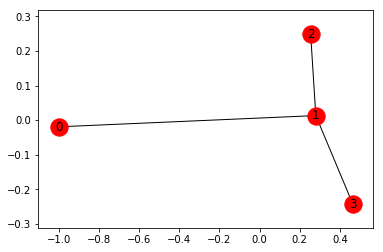

In [146]:
M1 = np.array([[0  ,.01,  0, 0],
               [.01,  0,  1,.5],
               [0  ,  1,  0, 0],
               [0  , .5,  0, 0]])
G_test = nx.Graph(M1)
spr = nx.spring_layout(G_test, scale=1)
nx.draw_networkx(G_test, pos=spr)

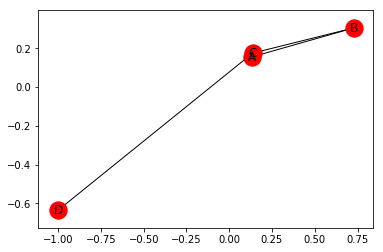

In [179]:
G2 = nx.Graph()
G2.add_edge('A', 'B', weight=0.5)
G2.add_edge('A', 'C', weight=10000)
G2.add_edge('B', 'C', weight=0.1)
G2.add_edge('C', 'D', weight=0.01)
#spr = nx.spring_layout(G2, scale=1, weight='weight')
nx.draw_networkx(G2)

In [399]:
cosine_sims = cosine_similarity(X)
#cosine_sims = cosine_similarity(X_centered)
cosine_sims.shape

(223, 223)

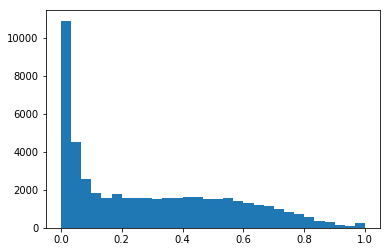

In [400]:
plt.hist(cosine_sims.flatten(), bins=30);

In [331]:
cosine_sims * (cosine_sims > 0.5).astype(int);

In [467]:
G_weighted = nx.Graph()
#node_colors = []
for i, num in enumerate(label_nums):
    G_weighted.add_node(i)
    #node_colors.append(np.array(['r','y','g','b','k'])[num])
edges_to_show = []
for i, row in enumerate(cosine_sims):
    for j in range(i+1, len(cosine_sims)):
        if cosine_sims[i,j] > 0.3:
            G_weighted.add_edge(i, j, weight=1000*cosine_sims[i,j])
        if cosine_sims[i,j] > 0.8:
            edges_to_show.append((i,j))

In [468]:
eigen_centralities = nx.eigenvector_centrality(G_weighted)
eigen_array = np.array([val for key, val in eigen_centralities.items()])
node_colors = [cm.jet(eig/np.max(eigen_array)) for eig in eigen_array]

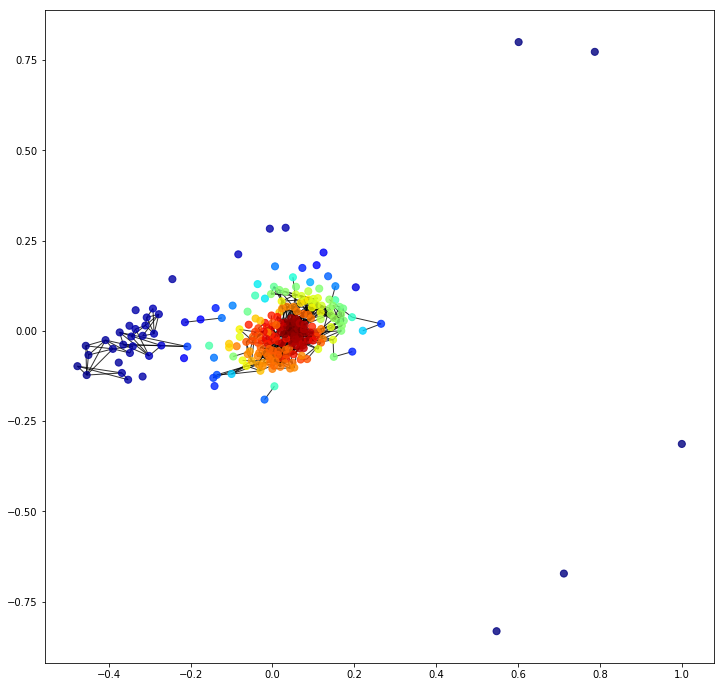

In [469]:
fig, ax = plt.subplots(figsize=(12,12))
spring = nx.spring_layout(G_weighted, k=2, weight='weight', seed=427)
nx.draw_networkx(G_weighted,
                 pos=spring,
                 node_size=50,
                 node_color=node_colors,
                 ax=ax,
                 alpha=0.8,
                 with_labels=False,
                 edgelist=edges_to_show)
#ax.set_xlim(left=-.4, right=.4)
#ax.set_ylim(bottom=-.4, top=.4);

In [384]:
bool_matrix = df.values.astype(bool)

In [328]:
G_jaccard = nx.Graph()
for i, row in enumerate(bool_matrix):
    for j in range(i+1, len(bool_matrix)):
        jac_sim = jaccard_similarity_score(row, bool_matrix[j])
        if jac_sim > 0.9:
            G_jaccard.add_edge(i, j, weight=5*jac_sim)

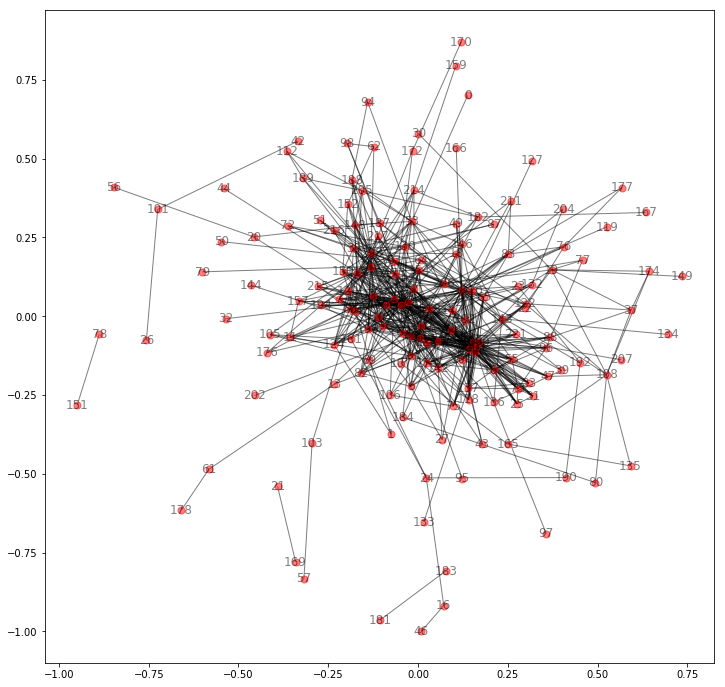

In [329]:
fig, ax = plt.subplots(figsize=(12,12))
spring = nx.spring_layout(G_jaccard, k=.5, weight='weight')
nx.draw_networkx(G_jaccard, pos=spring, node_size=50, ax=ax, alpha=0.5)
#ax.set_xlim(left=-.5, right=.5)
#ax.set_ylim(bottom=-.5, top=.5);

In [435]:
eigen_centralities = nx.eigenvector_centrality(G_weighted)
eigen_centralities.values()

TypeError: 'dict_values' object does not support indexing

In [427]:
np.flip(np.argsort(list(eigen_centralities.values())))

array([186,  89, 176, 213,  35, 124, 196, 188,  94,  69, 109, 146,  29,
       220,  60,  11,  44, 216, 145, 105, 148, 206,  99, 194, 192,  50,
       197, 156, 171, 185,  40,  28,  83,  45, 173,   8,   3, 142,  93,
        81,  76, 121,  52, 210, 130, 115, 187,  24, 111, 208,   7, 139,
       217,  53, 137,  63, 181, 183, 215, 205,  82,  65, 157, 175,   1,
        13,  68,  32, 195,   0, 117, 126, 116, 101,  15,  22, 161, 131,
        62, 132, 155,  86,  72, 100, 150,  74, 190, 143,  21,  39,   4,
       177,  23,  10, 182, 202, 169, 219,  87,  91,  42, 209, 144,   9,
       140, 160,  46, 212,   6,  16, 129,   2,  51, 154, 128,  17,  79,
       112, 203, 167,  48, 136, 106, 178, 152, 110, 218,  98, 103,  18,
        97, 134, 125,  49, 191, 138, 179,  14, 162, 164, 189, 166,  36,
       102,  64,  67, 184,  20, 172,  54, 170, 207,  71,  12,  38,  27,
       180, 222,  34, 127,  84, 204,  92,  61, 214,  43, 119,  66,  33,
        59,  85, 135, 133, 165, 104,  30,  57, 159, 158,  80, 10

In [445]:
np.array([val for key, val in eigen_centralities.items()])

array([7.12806987e-02, 7.37435687e-02, 1.85774011e-02, 1.01316313e-01,
       3.51161115e-02, 8.60543437e-21, 2.15841216e-02, 8.33902519e-02,
       1.01754800e-01, 2.57485077e-02, 3.32277163e-02, 1.40347557e-01,
       7.37487411e-04, 7.34326928e-02, 8.22208860e-03, 6.19771464e-02,
       2.03075695e-02, 1.73389466e-02, 1.08575011e-02, 5.20861255e-10,
       1.01685543e-03, 3.72178142e-02, 6.01581627e-02, 3.35148737e-02,
       8.91684845e-02, 3.25290583e-11, 2.62617016e-25, 7.16509538e-04,
       1.05736577e-01, 1.41743821e-01, 4.30098219e-06, 2.62617016e-25,
       7.15545752e-02, 1.27546037e-05, 4.73687907e-04, 1.56521533e-01,
       4.66012858e-03, 5.12830199e-10, 7.26387907e-04, 3.63181200e-02,
       1.06572045e-01, 5.51383542e-09, 2.92255703e-02, 1.39709238e-04,
       1.40147419e-01, 1.04986825e-01, 2.18598898e-02, 6.30959951e-07,
       1.53586776e-02, 9.53912465e-03, 1.22673934e-01, 1.83733147e-02,
       9.30923269e-02, 8.07408410e-02, 9.95162602e-04, 2.62617016e-25,
      

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 